# Preprocess the metadata for each dataset so that it's in a csv file: rows correspond to images, and columns are the filepath, class, and binary indicators of all of the potential concepts 

In [138]:
import os
import json
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random
from PIL import Image

## CLEVR

In [120]:
def extract_metadata_from_scene(scene_data):
    """Extract metadata (color, shape, size, material) from a single scene."""
    objects = scene_data['objects'][0]
    return {
        'color': objects['color'],
        'shape': objects['shape'],
        'size': objects['size'],
        'material': objects['material'],
        'image_filename': scene_data['image_filename']
    }

def track_unique_values(scene_files, scene_dir):
    """Track unique values for each concept across all scene files."""
    unique_values = {'color': set(), 'shape': set(), 'size': set(), 'material': set()}
    
    for json_file in scene_files:
        if json_file.endswith('.json'):
            json_path = os.path.join(scene_dir, json_file)
            with open(json_path, 'r') as f:
                scene_data = json.load(f)
            metadata = extract_metadata_from_scene(scene_data)
            
            unique_values['color'].add(metadata['color'])
            unique_values['shape'].add(metadata['shape'])
            unique_values['size'].add(metadata['size'])
            unique_values['material'].add(metadata['material'])
    
    # Sort the unique values for each concept
    return {concept: sorted(list(values)) for concept, values in unique_values.items()}

def create_concept_columns(unique_values):
    """Create concept columns for binary presence vectors."""
    columns = {'image_path': [], 'class': []}  # Add 'class' column here
    
    for concept, values in unique_values.items():
        for value in values:
            columns[f'{concept}::{value}'] = []

    return columns

def create_binary_presence_vector(metadata, unique_values, scene_data, columns):
    """Create a binary presence vector for a single scene."""
    color, shape, size, material = metadata['color'], metadata['shape'], metadata['size'], metadata['material']
    
    # Initialize row with 0 for each concept
    row = {key: 0 for key in columns.keys() if key != 'image_path' and key != 'class'}
    row['image_path'] = os.path.join('images', scene_data['image_filename'])
    
    # Set the corresponding concept columns to 1 if present
    row[f'color::{color}'] = 1
    row[f'shape::{shape}'] = 1
    row[f'size::{size}'] = 1
    row[f'material::{material}'] = 1
    
    # Set the 'class' column to the concatenated {color}_{shape}
    row['class'] = f'{color}_{shape}'
    
    return row

def process_scenes(scene_files, scene_dir, unique_values, columns):
    """Process all scenes and create binary presence vectors."""
    metadata_rows = []

    for json_file in scene_files:
        if json_file.endswith('.json'):
            json_path = os.path.join(scene_dir, json_file)
            with open(json_path, 'r') as f:
                scene_data = json.load(f)

            metadata = extract_metadata_from_scene(scene_data)
            row = create_binary_presence_vector(metadata, unique_values, scene_data, columns)
            metadata_rows.append(row)

    return metadata_rows

def save_metadata_to_csv(columns, metadata_rows, output_csv_path):
    """Save the extracted metadata to a CSV file."""
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(columns.keys())  # Write header (concepts + image_path)
        
        # Write the data rows by extracting values for each column
        for row in metadata_rows:
            writer.writerow([row[column] for column in columns])

def extract_clevr_metadata(base_dir='../Data/CLEVR'):
    """Extracts metadata (color, shape, image_path) and saves it to a CSV."""
    # Subdirectories for images and scenes
    image_dir = os.path.join(base_dir, 'images')
    scene_dir = os.path.join(base_dir, 'scenes')

    # Get all scene files
    scene_files = os.listdir(scene_dir)

    # Track unique values for each concept
    unique_values = track_unique_values(scene_files, scene_dir)

    # Create concept columns
    columns = create_concept_columns(unique_values)

    # Process scenes to generate binary presence vectors
    metadata_rows = process_scenes(scene_files, scene_dir, unique_values, columns)

    # Save metadata to CSV
    csv_file = os.path.join(base_dir, "metadata.csv")
    save_metadata_to_csv(columns, metadata_rows, csv_file)

    print(f"CLEVR metadata saved to {csv_file} :)")

# Call the function
extract_clevr_metadata()

CLEVR metadata saved to ../Data/CLEVR/metadata.csv :)


# CUB

In [130]:
def load_images(images_path):
    """Load the image paths and map image_id to image_path."""
    return pd.read_csv(images_path, sep=' ', header=None, names=['image_id', 'image_path'])

def load_class_labels(image_class_labels_path):
    """Load the class labels and map image_id to class_id."""
    return pd.read_csv(image_class_labels_path, sep=' ', header=None, names=['image_id', 'class_id'])

def load_class_names(class_names_path):
    """Load the class names mapping from class_id to class_name."""
    class_names_df = pd.read_csv(class_names_path, sep=' ', header=None, names=['class_id', 'class_name'])
    
    # Clean up the class_name by removing any leading zeros or numbers before the actual name
    # Split the string at the first dot (.) to extract the class name part
    class_names_df['class_name'] = class_names_df['class_name'].apply(lambda x: x.split('.', 1)[1])
    
    # Convert to a dictionary for faster lookup
    return class_names_df.set_index('class_id')['class_name'].to_dict()

def load_attributes(attributes_path):
    """Load the attributes and create a mapping of attribute_id to attribute_name."""
    attributes_df = pd.read_csv(attributes_path, sep=' ', header=None, names=['attribute_id', 'attribute_name'])
    attribute_mapping = {row['attribute_id']: row['attribute_name'] for _, row in attributes_df.iterrows()}
    return attributes_df, attribute_mapping

def process_image_attributes(image_attributes_path):
    """Process the image attribute labels and filter valid rows."""
    valid_rows = []
    invalid_image_ids = set()
    with open(image_attributes_path, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            
            # Only process lines with 5 elements
            if len(parts) == 5:
                image_id, attribute_id, is_present, certainty_id, time = map(float, parts)
                valid_rows.append([int(image_id), int(attribute_id), int(is_present), int(certainty_id), time])
            else:
                invalid_image_ids.add(int(parts[0]))

    attributes_df = pd.DataFrame(valid_rows, columns=['image_id', 'attribute_id', 'is_present', 'certainty_id', 'time'])
    return attributes_df, invalid_image_ids

def aggregate_attributes(attributes_df, invalid_image_ids):
    """Aggregate attributes by image_id and attribute_id, weighted by certainty."""
    # Remove invalid rows
    attributes_df = attributes_df[~attributes_df['image_id'].isin(invalid_image_ids)]
    
    # Calculate weighted_is_present
    attributes_df.loc[:, 'weighted_is_present'] = attributes_df['is_present'] * attributes_df['certainty_id']
    
    # Aggregate data
    aggregated_attributes_df = attributes_df.groupby(['image_id', 'attribute_id']).agg(
        weighted_is_present=('weighted_is_present', 'sum'),
        certainty_sum=('certainty_id', 'sum')
    ).reset_index()
    
    # Normalize weighted_is_present by certainty_sum
    aggregated_attributes_df['weighted_is_present'] = aggregated_attributes_df['weighted_is_present'] / aggregated_attributes_df['certainty_sum']
    aggregated_attributes_df.drop(columns=['certainty_sum'], inplace=True)

    return aggregated_attributes_df

def pivot_attributes(aggregated_attributes_df, attribute_mapping):
    """Pivot the attributes DataFrame and add the necessary columns."""
    # Convert weighted_is_present to binary (0 or 1) indicating presence/absence
    aggregated_attributes_df['is_present'] = (aggregated_attributes_df['weighted_is_present'] > 0).astype(int)

    # Map attribute_id to the actual attribute name
    aggregated_attributes_df['attribute_name'] = aggregated_attributes_df['attribute_id'].map(attribute_mapping)

    # Pivot the DataFrame
    return aggregated_attributes_df.pivot_table(
        index='image_id',
        columns='attribute_name',
        values='is_present',
        fill_value=0
    )

def add_image_paths_and_class_ids(pivoted_df, images_df, class_labels_df, class_names_mapping):
    """Add the image paths and class names to the pivoted DataFrame."""
    pivoted_df['image_path'] = pivoted_df.index.map(lambda x: 'images/' + images_df.loc[images_df['image_id'] == x, 'image_path'].values[0])
    
    # Only add the 'class' column and map class_id to class_name
    pivoted_df['class'] = pivoted_df.index.map(lambda x: class_labels_df.loc[class_labels_df['image_id'] == x, 'class_id'].values[0])
    pivoted_df['class'] = pivoted_df['class'].map(class_names_mapping)
    
    return pivoted_df


def save_metadata(pivoted_df, output_csv_path):
    """Save the final DataFrame to a CSV file."""
    pivoted_df.to_csv(output_csv_path, index=False)
    print(f"Saved CUB data to {output_csv_path} :)")

def extract_cub_metadata(base_dir='../Data/CUB'):
    """Main function to extract CUB metadata and save it to a CSV."""
    images_path = 'images.txt'
    image_class_labels_path = 'image_class_labels.txt'
    class_names_path = 'classes.txt'  # Assuming this file contains the mapping from class_id to class_name
    attributes_path = 'attributes/attributes.txt'
    image_attributes_path = 'attributes/image_attribute_labels.txt'
    output_csv_path = f'{base_dir}/metadata.csv'

    # Load data
    images_df = load_images(os.path.join(base_dir, images_path))
    class_labels_df = load_class_labels(os.path.join(base_dir, image_class_labels_path))
    class_names_mapping = load_class_names(os.path.join(base_dir, class_names_path))  # Load class names
    attributes_df, attribute_mapping = load_attributes(os.path.join(base_dir, attributes_path))
    attributes_df, invalid_image_ids = process_image_attributes(os.path.join(base_dir, image_attributes_path))

    # Aggregate attributes and pivot the DataFrame
    aggregated_attributes_df = aggregate_attributes(attributes_df, invalid_image_ids)
    pivoted_df = pivot_attributes(aggregated_attributes_df, attribute_mapping)

    # Add image paths and class names to the pivoted DataFrame
    pivoted_df = add_image_paths_and_class_ids(pivoted_df, images_df, class_labels_df, class_names_mapping)

    # Save the result to a CSV file
    save_metadata(pivoted_df, output_csv_path)

# Run the function
extract_cub_metadata()

/tmp/ipykernel_2012/2634584991.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes_df.loc[:, 'weighted_is_present'] = attributes_df['is_present'] * attributes_df['certainty_id']


Saved CUB data to ../Data/CUB/metadata.csv :)


## Sanity Check: Plot Random Images with Attributes

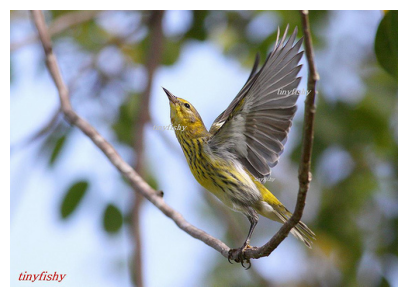

Image 9587 (images/163.Cape_May_Warbler/Cape_May_Warbler_0084_163132.jpg) attributes:
has_belly_color::brown, has_belly_color::yellow, has_belly_pattern::striped, has_bill_color::brown, has_bill_length::about_the_same_as_head, has_bill_shape::all-purpose, has_breast_color::brown, has_breast_color::yellow, has_breast_pattern::striped, has_crown_color::brown, has_crown_color::yellow, has_eye_color::black, has_forehead_color::brown, has_forehead_color::yellow, has_head_pattern::striped, has_leg_color::buff, has_leg_color::grey, has_nape_color::buff, has_nape_color::yellow, has_primary_color::brown, has_primary_color::yellow, has_shape::perching-like, has_size::small_(5_-_9_in), has_tail_shape::fan-shaped_tail, has_throat_color::brown, has_throat_color::yellow, has_under_tail_color::white, has_underparts_color::brown, has_underparts_color::yellow, has_upper_tail_color::brown, has_upper_tail_color::white, has_upper_tail_color::yellow, has_wing_color::grey, has_wing_pattern::striped, has_win

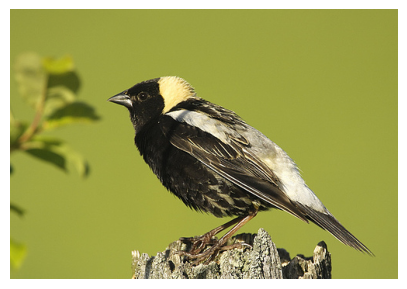

Image 714 (images/013.Bobolink/Bobolink_0117_10215.jpg) attributes:
has_bill_color::black, has_bill_length::shorter_than_head, has_bill_shape::cone, has_primary_color::black, has_primary_color::grey, has_shape::perching-like, has_size::small_(5_-_9_in)

----------------------------------------



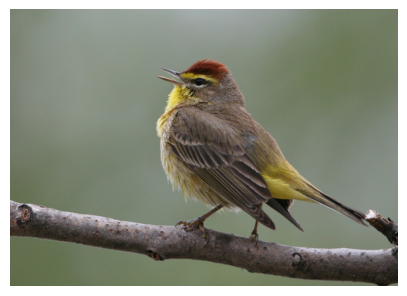

Image 10229 (images/174.Palm_Warbler/Palm_Warbler_0096_170867.jpg) attributes:
has_back_color::brown, has_back_color::buff, has_back_pattern::solid, has_belly_color::yellow, has_belly_pattern::solid, has_bill_color::grey, has_bill_length::shorter_than_head, has_bill_shape::all-purpose, has_breast_color::yellow, has_breast_pattern::solid, has_crown_color::brown, has_eye_color::black, has_forehead_color::brown, has_head_pattern::eyebrow, has_leg_color::buff, has_leg_color::grey, has_nape_color::brown, has_primary_color::brown, has_shape::perching-like, has_size::small_(5_-_9_in), has_tail_pattern::solid, has_tail_shape::pointed_tail, has_throat_color::yellow, has_under_tail_color::brown, has_underparts_color::yellow, has_upper_tail_color::yellow, has_upperparts_color::brown, has_wing_color::brown, has_wing_pattern::solid

----------------------------------------



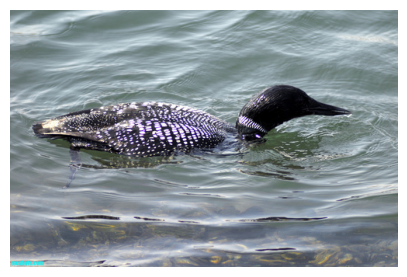

Image 4979 (images/086.Pacific_Loon/Pacific_Loon_0010_75818.jpg) attributes:
has_back_color::black, has_back_color::white, has_back_pattern::spotted, has_bill_color::black, has_bill_length::about_the_same_as_head, has_bill_shape::spatulate, has_crown_color::black, has_forehead_color::black, has_head_pattern::plain, has_nape_color::black, has_nape_color::white, has_primary_color::black, has_primary_color::white, has_shape::duck-like, has_size::medium_(9_-_16_in), has_tail_pattern::spotted, has_tail_shape::rounded_tail, has_upper_tail_color::black, has_upper_tail_color::white, has_upperparts_color::black, has_upperparts_color::white, has_wing_color::black, has_wing_color::white, has_wing_pattern::spotted, has_wing_shape::rounded-wings, has_wing_shape::tapered-wings

----------------------------------------



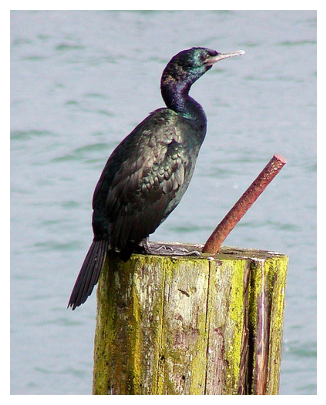

Image 1357 (images/025.Pelagic_Cormorant/Pelagic_Cormorant_0062_23623.jpg) attributes:
has_back_color::iridescent, has_belly_color::iridescent, has_belly_pattern::striped, has_bill_color::buff, has_bill_length::about_the_same_as_head, has_bill_shape::spatulate, has_breast_color::iridescent, has_breast_pattern::striped, has_crown_color::iridescent, has_eye_color::black, has_forehead_color::iridescent, has_head_pattern::masked, has_leg_color::grey, has_nape_color::iridescent, has_primary_color::iridescent, has_shape::upright-perching_water-like, has_size::medium_(9_-_16_in), has_tail_shape::pointed_tail, has_throat_color::iridescent, has_under_tail_color::iridescent, has_underparts_color::iridescent, has_upper_tail_color::iridescent, has_upperparts_color::iridescent, has_wing_color::iridescent, has_wing_shape::pointed-wings

----------------------------------------



In [131]:
def plot_random_images_with_attributes(base_dir='../Data/CUB/', num_images=5):
    # Load the DataFrame
    df = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
    
    # Pick random rows from the DataFrame (use index directly)
    random_images = random.sample(range(df.shape[0]), num_images)
    
    for idx in random_images:
        image_path = df.iloc[idx]['image_path']
        
        # Load the image
        image = Image.open(os.path.join(base_dir, image_path))
        
        # Plot the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        # Get the attributes that are present for this image
        attributes = df.iloc[idx].drop(['image_path']).index.tolist()
        attributes_present = [attr for attr in attributes if df.iloc[idx][attr] == 1]
        
        # Print the list of attributes
        print(f"Image {idx} ({image_path}) attributes:")
        print(", ".join(attributes_present))
        print("\n" + "-"*40 + "\n")

# Example usage
plot_random_images_with_attributes()

# Add Train/Test/Calibration Split Col

In [149]:
def add_split_column(dataset_name='CLEVR'):
    # Load the CSV file into a DataFrame
    filename = f'../Data/{dataset_name}/metadata.csv'
    df = pd.read_csv(filename)
    
    # Generate a random assignment for each row
    np.random.seed(42)
    random_values = np.random.choice(
        ['train', 'test', 'calibration'],
        size=len(df),
        p=[0.6, 0.2, 0.2]  # Probabilities for train, test, and calibration
    )
    
    # Add the new 'split' column to the DataFrame
    df['split'] = random_values
    
    # Save the modified DataFrame back to CSV
    df.to_csv(filename, index=False)
    
    print(f"Added split column to {filename} :)")

add_split_column(dataset_name='CUB')

Added split column to ../Data/CUB/metadata.csv :)
